![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2F03+-+BigQuery+ML+%28BQML%29&dt=03g+-+BQML+-+PCA+with+Anomaly+Detection.ipynb)

# 03g - BigQuery ML (BQML) - PCA with Anomaly Detection

In this notebook, BigQuery ML (BQML) is used to do a principal Component analysis (PCA).

**Principal component analysis, PCA**

Principal component analysis, or PCA, is a statistical technique for linearly transforming a set of features into a new coordinate system with fewer features all while preserving as much of the information (variation) as possible.  This is an unsupervised learning approach requiring no labels that results in a smaller feature set where the derived features/components are orthoganal to each other.  The number of components can be specified directly or set by the desired variance to be explained.  One way to think of this method is fitting an elipse with a number of dimensions, `p`, where the axes are orthogonal and their relative size represents amount of variance explained by the component (dimension).

Reference:
- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)
- [Vertex AI](https://cloud.google.com/vertex-ai)
    - [Documentation:](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [API:](https://cloud.google.com/vertex-ai/docs/reference)
        - [Clients:](https://cloud.google.com/vertex-ai/docs/start/client-libraries)
            - [Python SDK:](https://github.com/googleapis/python-aiplatform)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/aiplatform/latest)

**Conceptual Flow & Workflow**


---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'pca'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

from google.api import httpbody_pb2
import json

clients:

In [93]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

environment:

In [6]:
DIR = f"temp/{EXPERIMENT}"

!rm -rf {DIR}
!mkdir -p {DIR}

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table to build a model with BigQuery ML (BQML).

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [7]:
query = f"""
SELECT splits, {VAR_TARGET}, count(*) as n
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28455
1,TEST,1,47
2,TRAIN,0,227664
3,TRAIN,1,397
4,VALIDATE,0,28196
5,VALIDATE,1,48


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [10]:
query = f"""
WITH
    COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})
    
SELECT *,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
    SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
FROM COUNTS
"""
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,n_pct_class,n_pct_split,class_pct_total
0,TEST,1,47,0.095528,0.001649,0.001727
1,VALIDATE,1,48,0.097561,0.001699,0.001727
2,TRAIN,0,227664,0.800746,0.998259,0.998273
3,TRAIN,1,397,0.806911,0.001741,0.001727
4,TEST,0,28455,0.100083,0.998351,0.998273
5,VALIDATE,0,28196,0.099172,0.998301,0.998273


Retrive the rate of fraud, `Class = 1`, for the training data split.  This will be used later as the expected contamination rate for the records in the test split when doing anomaly detection.

In [11]:
TRAIN_FRAUD_PCT = review.loc[(review[f'{VAR_TARGET}'] == 1) & (review['splits'] == 'TRAIN'), 'n_pct_split'].values[0]
TRAIN_FRAUD_PCT

0.0017407623399002899

---
## This Run

In [12]:
print(f'This run with create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'The Timestamp Is: {TIMESTAMP}')

This run with create BQML model: statmike-mlops-349915.fraud.03_pca_20221110122913
The Timestamp Is: 20221110122913


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [PCA](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-pca) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created to subet to the training data
    - not directly used by the `PCA` training but used to subset to the `splits = 'TRAIN'` data for training

In [13]:
query = f"""
CREATE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'PCA',
        pca_explained_variance_ratio = 0.90,
        scale_features = TRUE,
        pca_solver = 'AUTO'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits, {VAR_TARGET})
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits = 'TRAIN'
"""
job = bq.query(query = query)
job.result()

In [14]:
(job.ended-job.started).total_seconds()

43.397

Add labels to the model in BigQuery:

In [15]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [16]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94811.116749,85134.000000,47493.531641,<NA>,0,<NA>
1,V1,-56.407510,2.454930,-0.000215,0.036678,1.958173,<NA>,0,<NA>
2,V2,-72.715728,22.057729,0.000316,0.059010,1.649662,<NA>,0,<NA>
3,V3,-48.325589,9.382558,-0.000525,0.174624,1.520173,<NA>,0,<NA>
4,V4,-5.600607,16.875344,0.000695,-0.034656,1.415309,<NA>,0,<NA>
5,V5,-113.743307,34.801666,-0.001264,-0.059681,1.381807,<NA>,0,<NA>
6,V6,-26.160506,73.301626,0.002089,-0.278266,1.334135,<NA>,0,<NA>
7,V7,-43.557242,120.589494,-0.000721,0.030419,1.245465,<NA>,0,<NA>
8,V8,-73.216718,19.168327,-0.001064,0.027016,1.205023,<NA>,0,<NA>
9,V9,-13.434066,15.594995,0.001406,-0.045622,1.100121,<NA>,0,<NA>


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [17]:
training_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
training_info

,training_run,iteration,duration_ms
0,0,0,6262


### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [18]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [19]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3s03_pca_20221110122913


---
## Evaluate Model

Review the evaluation statistics on the trials with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [20]:
eval = bq.query(
    query = f"""
        SELECT *
        FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
eval

,total_explained_variance_ratio
0,0.923359


Review the principal components with [ML.PRINCIPAL_COMPONENT_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-principal-component-info):

In [21]:
pc_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.PRINCIPAL_COMPONENT_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
pc_info

,principal_component_id,eigenvalue,explained_variance_ratio,cumulative_explained_variance_ratio
0,0,1.965330,0.065511,0.065511
1,1,1.681695,0.056056,0.121567
2,2,1.045826,0.034861,0.156428
3,3,1.027172,0.034239,0.190667
4,4,1.018633,0.033954,0.224622
5,5,1.013150,0.033772,0.258394
6,6,1.008045,0.033602,0.291995
7,7,1.006076,0.033536,0.325531
8,8,1.004075,0.033469,0.359000
9,9,1.003322,0.033444,0.392444


Review the principal components with [ML.PRINCIPAL_COMPONENTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-principal-components):

In [22]:
pc = bq.query(
    query = f"""
        SELECT *
        FROM ML.PRINCIPAL_COMPONENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
pc

,principal_component_id,feature,numerical_value,categorical_value
0,0,Time,0.031008,[]
1,0,V1,0.174601,[]
2,0,V2,0.395097,[]
3,0,V3,0.143194,[]
4,0,V4,-0.079480,[]
...,...,...,...,...
775,25,V25,0.131626,[]
776,25,V26,-0.010290,[]
777,25,V27,0.068330,[]
778,25,V28,-0.078994,[]


---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [23]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review the columns from the predictions.  Note that the query added columns for each principal component for each example in the test data.

In [24]:
pred.head()

,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6,principal_component_7,principal_component_8,principal_component_9,principal_component_10,...,principal_component_20,principal_component_21,principal_component_22,principal_component_23,principal_component_24,principal_component_25,principal_component_26,Class,transaction_id,splits
0,0.456469,0.610757,0.167874,-0.300040,0.036565,0.036770,0.028906,-0.046636,-0.663579,0.779318,...,-0.197223,0.126012,1.199103,0.039778,-0.635107,0.284296,-0.215734,0,9293ee0d-ba2c-4115-98c8-71ba645d2d72,TEST
1,0.433020,0.960371,0.101492,-0.015599,-0.473018,-0.383229,-0.929857,0.368817,0.197558,-0.871678,...,-1.013687,0.093626,0.143295,-0.227378,-0.701097,0.267889,-0.089955,0,bc680e58-83ea-4a66-9dfe-3ab68bee51b3,TEST
2,0.472239,-1.536484,0.078180,-0.122816,0.439561,1.190224,1.353671,0.957973,-0.615244,-0.476342,...,-0.005746,-0.727989,0.903623,1.146718,-0.131884,0.114081,-0.140885,0,006089eb-6378-43f8-a712-8d843faa26d3,TEST
3,-0.374779,0.821767,1.187871,-0.011543,2.464816,2.213998,0.660281,-0.689101,1.274002,-0.325478,...,0.149290,0.526586,-0.345220,-0.114253,-0.378887,1.626302,0.283688,0,1ba3a542-a218-4f00-8286-9eeaa58cef68,TEST
4,0.544691,-1.655535,0.201201,0.207364,0.406118,-0.218972,0.649833,-0.172246,0.205031,-0.713279,...,-0.584196,0.309849,0.118258,-0.924265,2.800096,-0.693553,0.445322,0,babe17fd-cdd0-471f-9388-5ae76cc4693e,TEST


---
## Anomalies
Use the [ML.DETECT_ANOMALIES](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies) function to retrieve rows that appear as anomalies with the input [contamination](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies#contamination) value set to the rate of fraud in the training data (calculated above).

In [25]:
query = f"""
WITH ANOMALIES AS (
        SELECT *
        FROM ML.DETECT_ANOMALIES (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
            (SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST')
          )
)
SELECT *
FROM ANOMALIES
WHERE is_anomaly = TRUE
"""
anomalies = bq.query(query = query).to_dataframe()

In [26]:
anomalies

,is_anomaly,mean_squared_error,Time,V1,V2,V3,V4,V5,V6,V7,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,True,5.130969,54082,-9.769940,-9.726317,-2.123246,3.096399,2.349314,-2.923753,-0.668008,...,3.969710,-0.000613,1.129806,0.641618,1.916157,-3.492635,20.00,0,2750b5eb-0b1d-4299-b6d6-5624b0498d73,TEST
1,True,76.904514,139135,-19.438377,-17.164140,-8.610240,4.073813,0.664572,-0.502303,6.491054,...,0.013644,0.459717,1.182505,0.161029,-9.543518,15.870474,0.76,0,26a30520-549e-4833-b25b-eeb6fd6fe4bd,TEST
2,True,87.240561,126271,-19.618019,-18.539382,-4.310085,6.787660,3.201194,-0.760207,2.172656,...,-6.637055,0.754359,0.335719,-0.501723,-8.703068,16.129609,175.00,0,efd74f88-9ba0-4ffb-8966-9aaa8a9c0be1,TEST
3,True,15.790477,137934,-15.168474,-19.190285,-1.749319,2.999120,8.141815,-4.746811,-5.319852,...,-5.041949,-0.983799,-1.076277,-0.460614,2.756117,-4.639338,814.25,0,53b1be4c-01ae-48d3-a066-7a35bd800079,TEST
4,True,8.579512,133013,-8.250844,-4.848971,-1.815623,0.332288,0.038812,0.103141,1.088345,...,-2.497822,0.518712,-0.017827,-0.542502,-2.950622,4.484648,319.60,0,acf9ab00-28ad-4500-9645-6ad0b240a492,TEST
5,True,8.091865,28197,-6.243976,-3.778666,2.100628,-0.735784,1.538913,0.042233,2.884848,...,-1.302455,0.235380,0.216960,-1.013667,-6.250280,1.609820,106.02,0,dbd72c31-068e-48ea-ac13-79e96b6f1563,TEST
6,True,5.851708,32333,-8.232703,-9.432747,1.824590,2.772793,9.851763,-7.635055,-6.959433,...,-1.528614,0.670383,-0.772622,0.125317,1.468079,-0.441010,3.59,0,ffd1260f-0558-43ff-8be3-ed69f314f8b6,TEST
7,True,11.029368,74657,-16.743851,-19.511968,-7.214609,8.345571,-11.322894,8.606982,14.113144,...,9.016942,-0.859535,1.048808,0.438797,4.250372,-5.954281,3759.39,0,03324231-8b4c-4a98-a521-ab626f5d232d,TEST
8,True,5.837494,43155,-3.974601,-4.465240,-3.993802,2.913663,-2.750074,3.419696,0.005277,...,-13.513892,-0.858127,-2.829282,-0.391484,2.099804,0.084728,3000.00,0,6b840789-8d93-4cae-bae2-36e6d02b93da,TEST
9,True,5.491340,63302,-1.067709,-0.885098,2.146532,0.620595,5.480892,-2.393705,-7.216245,...,-9.873411,-0.855139,-1.292436,-0.574897,0.711660,0.507173,9.99,0,e116ffb0-8b57-49b2-b19e-26a2bcc67f6c,TEST


Use anomaly detection information to create confusion matrix with know classification:

In [27]:
query = f"""
WITH ANOMALIES AS (
        SELECT {VAR_TARGET},
            CASE
                WHEN is_anomaly = TRUE THEN 1
                WHEN is_anomaly = FALSE THEN 0
            END as predicted_{VAR_TARGET}
        FROM ML.DETECT_ANOMALIES (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
            (SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST')
          )
      )
SELECT predicted_{VAR_TARGET}, {VAR_TARGET}, count(*) as count
FROM ANOMALIES
GROUP BY predicted_{VAR_TARGET}, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,predicted_Class,Class,count
0,0,0,28398
1,0,1,47
2,1,0,57


---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [30]:
query = f"""
SELECT {VAR_TARGET},
    CASE
        WHEN is_anomaly = TRUE THEN 1
        WHEN is_anomaly = FALSE THEN 0
    END as predicted_{VAR_TARGET}
FROM ML.DETECT_ANOMALIES (
    MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
    (SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
results = bq.query(query = query).to_dataframe()
results

,Class,predicted_Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
28497,0,0
28498,0,0
28499,0,0
28500,0,0


In [45]:
metrics.confusion_matrix(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}']))

array([[28398,    57],
       [   47,     0]])

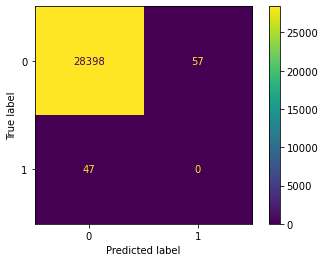

In [46]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}']))
)
disp.plot()

In [47]:
metrics.accuracy_score(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}']))

0.9963511332538068

In [48]:
print(metrics.classification_report(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}'])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28455
           1       0.00      0.00      0.00        47

    accuracy                           1.00     28502
   macro avg       0.50      0.50      0.50     28502
weighted avg       1.00      1.00      1.00     28502



---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [49]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [50]:
(export.ended - export.started).total_seconds()

25.057

In [51]:
listing = !gsutil ls {URI}/models/{TIMESTAMP}/model
listing

['gs://statmike-mlops-349915/03/pca/models/20221110122913/model/',
 'gs://statmike-mlops-349915/03/pca/models/20221110122913/model/saved_model.pb',
 'gs://statmike-mlops-349915/03/pca/models/20221110122913/model/variables/']

In [52]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/03/pca/models/20221110122913/model?project=statmike-mlops-349915


### Detect The Model Types Framework

In [53]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(filetypes) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = TensorFlow


Set the `DEPLOY_IMAGE` based on the framework:

In [54]:
if framework == 'TensorFlow':
    DEPLOY_IMAGE = TF_DEPLOY_IMAGE
elif framework == 'XGBoost':
    DEPLOY_IMAGE = XGB_DEPLOY_IMAGE
    
DEPLOY_IMAGE

'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'

### Upload The Model To Vertex AI Model Registry

References:
- [aiplatform.Model](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [55]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, adding to model registry as version 1')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'timestamp': f'{TIMESTAMP}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

Model Already in Registry:
Loading model as new default version.
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_03_pca/operations/7723538464607567872
Model created. Resource name: projects/1026793852137/locations/us-central1/models/5058347224048599040@2
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/5058347224048599040@2')


In [56]:
model.display_name

'03_pca'

In [57]:
model.resource_name

'projects/1026793852137/locations/us-central1/models/5058347224048599040'

In [58]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{SERIES}_{EXPERIMENT}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03_pca?project=statmike-mlops-349915


---
## Online Predictions with Vertex AI Endpoints

### Create/Retrieve An Endpoint
References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [94]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/6193790891820318720
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/6193790891820318720?project=statmike-mlops-349915


In [95]:
endpoint.display_name

'03'

In [96]:
endpoint.traffic_split

{'2690746845725982720': 100}

In [97]:
deployed_models = endpoint.list_models()
#deployed_models

### Deploy Model To Endpoint

In [98]:
if (model.display_name, model.version_id) not in [(deployed_model.display_name, deployed_model.model_version_id) for deployed_model in endpoint.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )
else: 
    print(f'The current model/version is already deployed.')

The current model/version is already deployed.


### Remove Deployed Models without Traffic

In [99]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model 03_pca with version 2 has traffic = 100


In [100]:
endpoint.traffic_split

{'2690746845725982720': 100}

In [101]:
#endpoint.list_models()

---
## Prediction

### Retrieve Records For Prediction

In [102]:
n = 10
pred = bq.query(query = f"SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE splits='TEST' LIMIT {n}").to_dataframe()

In [103]:
pred.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST
4,165236,2.180149,0.218732,-2.637726,0.348776,1.063546,-1.249197,0.942021,-0.547652,-0.087823,...,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.0,0,c8a5b93a-1598-4689-80be-4f9f5df0b8ce,TEST


Shape as instances: dictionaries of key:value pairs for only features used in model

In [104]:
newobs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET,'splits'])]].to_dict(orient='records')
#newobs[0]

In [105]:
len(newobs)

10

In [106]:
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

### Get The Model Signature Name (if TensorFlow)

In [107]:
if model.labels['framework'] == 'tensorflow':
    import tensorflow as tf
    reloaded_model = tf.saved_model.load(model.uri)
    print(list(reloaded_model.signatures.keys())[0])

serving_default


### Get The Feature Order (if XGBoost)

In [108]:
if model.labels['framework'] == 'xgboost':
    import gcsfs
    import tensorflow as tf
    file = f'{model.uri}/assets/model_metadata.json'
    if tf.io.gfile.exists(file):
        gcs = gcsfs.GCSFileSystem(project = PROJECT_ID)
        with gcs.open(file) as fp:
            features = json.load(fp)['feature_names']
    else:
        features = list(newobs[0].keys())

### Prepare Instance For Prediction

Depending on which framework the model is trained with the instance format may be different.  More information can be found [here](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#request-body-details).

Instances:

In [109]:
if model.labels['framework'] == 'tensorflow':
    instances = {"instances": [newob for newob in newobs[0:1]], "signature_name": list(reloaded_model.signatures.keys())[0]}
elif model.labels['framework'] == 'xgboost':
    instances = {"instances": [[newob[f] for f in features] for newob in newobs[0:1]]}
    
http_body = httpbody_pb2.HttpBody(
    data = json.dumps(instances).encode("utf-8"),
    content_type = "application/json"
)

In [110]:
print(instances)

{'instances': [{'Time': 35337, 'V1': 1.0928441854981998, 'V2': -0.0132303486713432, 'V3': 1.35982868199426, 'V4': 2.7315370965921004, 'V5': -0.707357349219652, 'V6': 0.8738370029866129, 'V7': -0.7961301510622031, 'V8': 0.437706509544851, 'V9': 0.39676985012996396, 'V10': 0.587438102569443, 'V11': -0.14979756231827498, 'V12': 0.29514781622888103, 'V13': -1.30382621882143, 'V14': -0.31782283120234495, 'V15': -2.03673231037199, 'V16': 0.376090905274179, 'V17': -0.30040350116459497, 'V18': 0.433799615590844, 'V19': -0.145082264348681, 'V20': -0.240427548108996, 'V21': 0.0376030733329398, 'V22': 0.38002620963091405, 'V23': -0.16764742731151097, 'V24': 0.0275573495476881, 'V25': 0.59211469704354, 'V26': 0.219695164116351, 'V27': 0.0369695108704894, 'V28': 0.010984441006191, 'Amount': 0.0}], 'signature_name': 'serving_default'}


### Get Predictions: Python Client

Using Raw Prediction here. This is methods of export from BigQuery have different model signatures and raw prediction client for Vertex AI allow the signature to be include in the request.

Reference:
- [aiplatform.gapic.PredictionSerivceClient.raw_predict()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_raw_predict)

In [113]:
#endpoint.raw_predict(body = json.dumps(instances).encode('utf-8'), headers = {'content_type': 'application/json'})

Client:

In [114]:
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
predictor = aiplatform.gapic.PredictionServiceClient(client_options = client_options)

Prediction:

In [115]:
prediction = predictor.raw_predict(
    endpoint = endpoint.resource_name,
    http_body = http_body
)

In [116]:
#prediction

Format raw prediction response using JSON:

In [117]:
prediction = json.loads(prediction.data)
prediction

{'predictions': [{'principal_component_ids': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25],
   'principal_component_projections': [0.40618614670496467,
    1.1424290367670222,
    0.17976017357251153,
    -0.027121364010871563,
    0.24193181024490562,
    -0.17179728597600719,
    1.9639699259239043,
    0.3381761316515224,
    0.24131684750892923,
    0.8576724721238839,
    -1.0001302234224472,
    1.0044319605432956,
    -1.6128315991233622,
    -0.31470797236210296,
    1.0134031186771921,
    0.7075492028374176,
    -1.584721170444826,
    -0.15879433906946427,
    -0.08639166102246394,
    0.5986228270738121,
    -0.8235495575977535,
    -0.6350921716448534,
    -0.6830334984171708,
    0.20112866720848538,
    -0.2954770089315091,
    0.08770761978421224]}]}

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:rawPredict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_raw_predict)

Prepare request:

In [118]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps(instances))

Prediction:

In [119]:
prediction = !curl -s POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict

In [120]:
#prediction

Format raw prediction response using JSON:

In [121]:
prediction = json.loads(''.join([p.strip() for p in prediction]))
prediction

{'predictions': [{'principal_component_ids': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25],
   'principal_component_projections': [0.40618614670496467,
    1.1424290367670222,
    0.17976017357251153,
    -0.027121364010871563,
    0.24193181024490562,
    -0.17179728597600719,
    1.9639699259239043,
    0.3381761316515224,
    0.24131684750892923,
    0.8576724721238839,
    -1.0001302234224472,
    1.0044319605432956,
    -1.6128315991233622,
    -0.31470797236210296,
    1.0134031186771921,
    0.7075492028374176,
    -1.584721170444826,
    -0.15879433906946427,
    -0.08639166102246394,
    0.5986228270738121,
    -0.8235495575977535,
    -0.6350921716448534,
    -0.6830334984171708,
    0.20112866720848538,
    -0.2954770089315091,
    0.08770761978421224]}]}

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints raw-predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/raw-predict)

Prepare request:

In [122]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps(instances))

Prediction:

In [123]:
prediction = !gcloud ai endpoints raw-predict \
{endpoint.name.rsplit('/',1)[-1]} \
--region={REGION} --format="json" --request=@{DIR}/request.json

In [124]:
#prediction

Format raw prediction response using JSON:

In [125]:
prediction = json.loads("".join(prediction[1:]))
prediction

{'predictions': [{'principal_component_ids': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25],
   'principal_component_projections': [0.40618614670496467,
    1.1424290367670222,
    0.17976017357251153,
    -0.027121364010871563,
    0.24193181024490562,
    -0.17179728597600719,
    1.9639699259239043,
    0.3381761316515224,
    0.24131684750892923,
    0.8576724721238839,
    -1.0001302234224472,
    1.0044319605432956,
    -1.6128315991233622,
    -0.31470797236210296,
    1.0134031186771921,
    0.7075492028374176,
    -1.584721170444826,
    -0.15879433906946427,
    -0.08639166102246394,
    0.5986228270738121,
    -0.8235495575977535,
    -0.6350921716448534,
    -0.6830334984171708,
    0.20112866720848538,
    -0.2954770089315091,
    0.08770761978421224]}]}

---
## Remove Resources
see notebook "99 - Cleanup"